## Importing Python Packages

In [2]:
import os
import pathlib
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm.autonotebook import tqdm;

plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

/tmp/ipykernel_49571/1197695707.py:16: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm;


In [3]:
seed = 17
torch.manual_seed(seed);
random.seed(seed)
torch.backends.cudnn.benchmark = True

In [4]:
tag = datetime.now()
tag = tag.strftime("%Y-%m-%d-%H-%M-%S")
tag += '-RadarNet-Short-V0'
tag

'2023-05-03-15-17-34-RadarNet-Short-V0'

## RadarPCL Model

In [5]:
class RadarPCL(nn.Module):
    
    def __init__(self,seq_len=4):
        super(RadarPCL, self).__init__()
        self.seq_len = seq_len
        self.conv_top = nn.Sequential(
            self._conv(4, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
        )
        self.conv_front = nn.Sequential(
            self._conv(4, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
        )
        self.linear_top = nn.Sequential(
            nn.Linear(4*4*64, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Linear(64, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 16, bias=False),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Linear(16, 8, bias=False),
            nn.BatchNorm1d(8),
            nn.GELU(),
            nn.Linear(8, 4, bias=False),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 2, bias=False),
            nn.BatchNorm1d(2),
            nn.GELU(),
            nn.Linear(2, 1, bias=False),
            nn.BatchNorm1d(1),
            nn.GELU()
        )
        self.linear_front = nn.Sequential(
            nn.Linear(4*4*64, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Linear(64, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 16, bias=False),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Linear(16, 8, bias=False),
            nn.BatchNorm1d(8),
            nn.GELU(),
            nn.Linear(8, 4, bias=False),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 2, bias=False),
            nn.BatchNorm1d(2),
            nn.GELU(),
            nn.Linear(2, 1, bias=False),
            nn.BatchNorm1d(1),
            nn.GELU()
        )
        
    def _conv(self, in_channel, out_channel, kernel_size, stride, padding, dilation, groups):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.GELU()
        )
    
    def forward(self, I_top, I_front):
        batch_size = I_top.size(0)
        # Top-View
        x_top = self.conv_top(I_top)
        x_top = x_top.view(batch_size, -1)
        x_top = self.linear_top(x_top)
        # Front-View
        x_front = self.conv_front(I_front)
        x_front = x_front.view(batch_size, -1)
        x_front = self.linear_front(x_front)
        # Adding speed components
        x = x_top + x_front
        return x

In [6]:
seq_len = 1

In [7]:
model = RadarPCL(seq_len=seq_len)

In [8]:
summary(model, input_size=[(1, 4, 100, 100),(1, 4, 100, 100)])

/home/paulo/.pyenv/versions/venv.3.10.11/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/paulo/.pyenv/versions/venv.3.10.11/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RadarPCL                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 4, 4]             --
│    └─Sequential: 2-1                   [1, 64, 76, 76]           --
│    │    └─Conv2d: 3-1                  [1, 64, 76, 76]           12,544
│    │    └─BatchNorm2d: 3-2             [1, 64, 76, 76]           128
│    │    └─GELU: 3-3                    [1, 64, 76, 76]           --
│    └─Sequential: 2-2                   [1, 64, 52, 52]           --
│    │    └─Conv2d: 3-4                  [1, 64, 52, 52]           200,704
│    │    └─BatchNorm2d: 3-5             [1, 64, 52, 52]           128
│    │    └─GELU: 3-6                    [1, 64, 52, 52]           --
│    └─Sequential: 2-3                   [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-7                  [1, 64, 28, 28]           200,704
│    │    └─BatchNorm2d: 3-8             [1, 64, 28, 28]           12

## Dataset Class

In [9]:
class RadarDataset(Dataset):
    
    def __init__(self, path, seq_len=1, px=150, py=150, pz=150, rx=19.3*2, ry=19.3, rz=10., dAzi=15., dElev=15., dRoll=15., augment=True, transform=None):
        super(RadarDataset, self).__init__()
        
        self.path = path
        self.seq_len = seq_len
        self.px = px
        self.py = py
        self.pz = pz
        self.rx = rx
        self.ry = ry
        self.rz = rz
        self.dAzi = dAzi
        self.dElev = dElev
        self.dRoll = dRoll
        self.augment = augment
        self.transform = transform
        
        _, _, files = next(os.walk(path))
        print(f'>>> Found {len(files)} files in the selected directory. Building dataset...')
        pbar = tqdm(total=len(files))
        
        self.offset_dict = {}
        self.length = 0
        pathlib.Path(self.path + 'Processed').mkdir(parents=True, exist_ok=True)
    
        # Creating unified file to optimize RAM
        with open(self.path + 'Processed/unified-seq.txt', 'w') as u:
            for file in files:
                with open(self.path + file, 'r') as f:
                    # Data is a list(timestamp, list(detections), speed)
                    data = f.read().splitlines()
                    for i in range(seq_len-1, len(data)):
                        group = []
                        status = []
                        for j in range(i, i - seq_len, -1):
                            # Evaluating current line
                            curr = eval(data[j])
                            group.append([curr[1],curr[2]])
                            status.append(curr[3])
                        # Saving data in a unified file if it contains at least one valid scan
                        if status[0] > 0:
                            self.offset_dict[self.length] = u.tell()
                            u.write(str(group)+'\n')
                            self.length += 1
                pbar.update(n=1)
            
        
    def __len__(self):
        return len(self.offset_dict)
    

    def __getitem__(self, id):
        # Reading data on demand
        offset = self.offset_dict[id]
        with open(self.path + 'Processed/unified-seq.txt', 'r', encoding='utf-8') as f:
            f.seek(offset)
            line = f.readline()
            # Processing recovered data
            group = eval(line)
            # Computing random angles to be used in the sequence
            dAzi = random.uniform(-self.dAzi,self.dAzi) * np.pi/180.
            dElev = random.uniform(-self.dElev,self.dElev) * np.pi/180.
            dRoll = random.uniform(-self.dRoll,self.dRoll) * np.pi/180.
            # Lists to store the sequence of data
            I_top_scans = []
            I_front_scans = []
            curr_speed = 0.
            for i, (data, speed) in enumerate(group):
                data = np.array(data)
                # Augmenting data
                if self.augment:
                    data = self._rotate(data, dAzi, dElev, dRoll)
                # We normalize the position vector to get speed components
                n = data[:,:3] / np.expand_dims(np.linalg.norm(data[:,:3], axis=1), axis=1)
                speed_xyz = n * np.expand_dims(data[:,5],axis=1)
                # Preparing tensors
                I_top = self._top(np.copy(data), speed_xyz, px=self.px, py=self.py, rx=self.rx, ry=self.ry)
                I_top = self.transform(I_top)
                I_front = self._front(np.copy(data), speed_xyz, px=self.px, pz=self.pz, rx=self.rx, rz=self.rz)
                I_front = self.transform(I_front)
                I_top_scans.append(I_top)
                I_front_scans.append(I_front)
                if i == 0:
                    curr_speed = speed
            I_top_scans = torch.cat(I_top_scans, dim=0)
            I_front_scans = torch.cat(I_front_scans, dim=0)
            speeds = torch.FloatTensor([curr_speed])
        return I_top_scans, I_front_scans, speeds
    
    
    def _rotate(self, data, dAzi, dElev, dRoll):
        ''' data has columns in the following order: x, y, z, rcs, snr, speed '''
        # Rotating points
        Rz = np.array([[np.cos(dAzi), -np.sin(dAzi), 0.],
                       [np.sin(dAzi), np.cos(dAzi), 0.],
                       [0., 0., 1.]])
        Ry = np.array([[np.cos(dElev), 0., np.sin(dElev)],
                       [0., 1., 0.],
                       [-np.sin(dElev), 0., np.cos(dElev)]])
        Rx = np.array([[1., 0., 0.],
                       [0., np.cos(dRoll), -np.sin(dRoll)],
                       [0., np.sin(dRoll), np.cos(dRoll)]])
        R = Rz @ Ry @ Rx
        pts = data[:,:3].T
        pts = R.dot(pts).T
        data[:,:3] = pts
        return data
        
    
    def _top(self, P, speed_xyz, px, py, rx, ry):
        ''' P has columns in the following order: x, y, z, rcs, snr, speed '''
        # Adjusting coordinates from radar to image
        P[:, [0,1]] = P[:, [1,0]]
        P[:, 0] *= -1
        I = np.zeros((py,px,4), dtype=np.float32)
        T = np.zeros((P.shape[0],2), dtype=np.uint16)
        # Computing mapped positions
        T[:,1] = np.uint16(np.maximum(np.minimum((px/rx) * P[:,0] + (px/2), px-1), 0))    
        T[:,0] = np.uint16(np.maximum(np.minimum((py/ry) * P[:,1], py-1), 0))
        # Mapping the space to the first layer
        I[T[:,0],T[:,1],0] = np.squeeze(P[:,2])
        # Mapping the rcs to the second layer
        I[T[:,0],T[:,1],1] = np.squeeze(P[:,3])
        # Mapping the snr to the second layer
        I[T[:,0],T[:,1],2] = np.squeeze(P[:,4])
        # Mapping the speed to the forth layer
        # In the top view, speed is composed by x and y
        I[T[:,0],T[:,1],3] = np.squeeze(speed_xyz[:,0]+speed_xyz[:,1])
        return I
    
    
    def _front(self, P, speed_xyz, px, pz, rx, rz):
        ''' P has columns in the following order: x, y, z, rcs, snr, speed '''
        # Adjusting coordinates from radar to image
        P[:, [0,1]] = P[:, [1,0]]
        P[:, 0] *= -1
        I = np.zeros((pz,px,4), dtype=np.float32)
        T = np.zeros((P.shape[0],2), dtype=np.uint16)
        # Computing mapped positions
        T[:,1] = np.uint16(np.maximum(np.minimum((px/rx) * P[:,0] + (px/2), px-1), 0))    
        T[:,0] = np.uint16(np.maximum(np.minimum((pz/rz) * P[:,2] + (pz/2), pz-1), 0))
        # Mapping the space to the first layer
        I[T[:,0],T[:,1],0] = np.squeeze(P[:,1])
        # Mapping the rcs to the second layer
        I[T[:,0],T[:,1],1] = np.squeeze(P[:,3])
        # Mapping the snr to the second layer
        I[T[:,0],T[:,1],2] = np.squeeze(P[:,4])
        # Mapping the speed to the forth layer
        # In the front view, speed is composed by z
        I[T[:,0],T[:,1],3] = np.squeeze(speed_xyz[:,2])
        return I

## Functions

In [10]:
def train_epoch(model, dataloader, loss_fn, optimizer, scheduler, device):
    model.train()
    train_loss = 0.
    for I_top, I_front, speed in dataloader:
        # plot_tensor(I_top[0,:,:,:], I_front[0,:,:,:])
        # print(I_top.size(),I_front.size(), speed.size())
        # break
        I_top = I_top.to(device=device)
        I_front = I_front.to(device=device)
        speed = speed.to(device=device)
        y = model(I_top, I_front)
        loss = loss_fn(speed, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [11]:
def test_epoch(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for I_top, I_front, speed in dataloader:
            I_top = I_top.to(device=device)
            I_front = I_front.to(device=device)
            speed = speed.to(device=device)
            y = model(I_top, I_front)
            loss = loss_fn(speed, y)
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)

In [12]:
def preview(model, dataloader, device, path, epoch, lr, show=False):
    model.eval()
    ref = []
    est = []
    with torch.no_grad():
        for I_top, I_front, speed in dataloader:
            I_top = I_top.to(device=device)
            I_front = I_front.to(device=device)
            speed = speed.to(device=device)
            y = model(I_top, I_front)
            ref.append(speed.cpu().numpy()[0][0])
            est.append(y.cpu().numpy()[0][0])
    fig, ax = plt.subplots(figsize=[12.8, 4.8])
    ax.plot(est, 'r', linewidth=0.5, label='$\hat{\mathbf{x}}$')
    ax.plot(ref, 'b', linewidth=0.75, label='$\mathbf{x}$')
    ax.set_xlabel('Samples')
    ax.set_ylabel('m/s')
    ax.legend(loc='upper left', fancybox=False)
    ax.text(0, 1, f'LR = {lr}',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    plt.savefig(path + 'epoch_' + str(epoch).rjust(4, '0') + '.png')
    if show:
        plt.show()
    plt.close(fig)        
    return None

In [13]:
def plot_tensor(I_top, I_front):
    ''' Expecting tensors with C x H x W '''
    fig = plt.figure(figsize=(24,12))
    fig.tight_layout()
    # fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4,figsize=(16,8), sharey=True, sharex=True)
    ax5 = plt.subplot(245)
    ax1 = plt.subplot(241,sharex=ax5)
    ax2 = plt.subplot(242,sharey=ax1)
    ax3 = plt.subplot(243,sharey=ax1)
    ax4 = plt.subplot(244,sharey=ax1)
    ax6 = plt.subplot(246,sharey=ax5)
    ax7 = plt.subplot(247,sharey=ax5)
    ax8 = plt.subplot(248,sharey=ax5)
    cm = 'cividis'
    ###
    ax1.set_title('Top-View (Space)')
    im1 = ax1.imshow(I_top[0,:,:], cmap=cm)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb1 = plt.colorbar(im1, cax=cax)
    cb1.ax.set_title('$\mathbf{z}~[m]$')
    ax1.set_yticks(ticks=[0,int(py/2),py-1])
    ax1.set_yticklabels(['0.0',str(round(ry/2,1)),str(round(ry,1))])
    ax1.set_ylabel('$\mathbf{y}~[m]$', rotation=0, labelpad=20)
    ###
    ax2.set_title('Top-View (RCS)')
    im2 = ax2.imshow(I_top[1,:,:], cmap=cm)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb2 = plt.colorbar(im2, cax=cax)
    cb2.ax.set_title('$\mathbf{RCS}$')
    ###
    ax3.set_title('Top-View (SNR)')
    im3 = ax3.imshow(I_top[2,:,:], cmap=cm)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb3 = plt.colorbar(im3, cax=cax)
    cb3.ax.set_title('$\mathbf{SNR}$')
    ###
    ax4.set_title('Top-View (Speed)')
    im4 = ax4.imshow(I_top[3,:,:], cmap=cm)
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb4 = plt.colorbar(im4, cax=cax)
    cb4.ax.set_title('$\mathbf{Speed}$')
    ###
    ax5.set_title('Front-View (Space)')
    im5 = ax5.imshow(I_front[0,:,:], cmap=cm)
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb5 = plt.colorbar(im5, cax=cax)
    cb5.ax.set_title('$\mathbf{y}~[m]$')
    ax5.set_xticks(ticks=[0,int(px/2),px-1])
    ax5.set_xticklabels([str(round(-rx/2,1)),'0.0',str(round(rx/2,1))])
    ax5.set_yticks(ticks=[0,int(pz/2),pz-1])
    ax5.set_yticklabels([str(round(-rz/2,1)),'0.0',str(round(rz/2,1))])
    ax5.set_xlabel('$\mathbf{x}~[m]$')
    ax5.set_ylabel('$\mathbf{z}~[m]$', rotation=0, labelpad=20)
    ###
    ax6.set_title('Front-View (RCS)')
    im6 = ax6.imshow(I_front[1,:,:], cmap=cm)
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb6 = plt.colorbar(im6, cax=cax)
    cb6.ax.set_title('$\mathbf{RCS}$')
    ax6.set_xticks(ticks=[0,int(px/2),px-1])
    ax6.set_xticklabels([str(round(-rx/2,1)),'0.0',str(round(rx/2,1))])
    ax6.set_xlabel('$\mathbf{x}~[m]$')
    ###
    ax7.set_title('Front-View (SNR)')
    im7 = ax7.imshow(I_front[2,:,:], cmap=cm)
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb7 = plt.colorbar(im7, cax=cax)
    cb7.ax.set_title('$\mathbf{SNR}$')
    ax7.set_xticks(ticks=[0,int(px/2),px-1])
    ax7.set_xticklabels([str(round(-rx/2,1)),'0.0',str(round(rx/2,1))])
    ax7.set_xlabel('$\mathbf{x}~[m]$')
    ###
    ax8.set_title('Front-View (Speed)')
    im8 = ax8.imshow(I_front[3,:,:], cmap=cm)
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb8 = plt.colorbar(im8, cax=cax)
    cb8.ax.set_title('$\mathbf{Speed}$')
    ax8.set_xticks(ticks=[0,int(px/2),px-1])
    ax8.set_xticklabels([str(round(-rx/2,1)),'0.0',str(round(rx/2,1))])
    ax8.set_xlabel('$\mathbf{x}~[m]$')
    
    plt.show();
    
    return None

## Preparing Datasets and Dataloaders

In [17]:
t = transforms.Compose([transforms.ToTensor()])

In [18]:
px = 100
py = 100
pz = 100
rx = 20. * 2
ry = 20.
rz = 15.
dAzi = 15.
dElev = 15.
dRoll = 15.

In [19]:
train_data = RadarDataset('../synched/fr_V0/train/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, dAzi=dAzi, dElev=dElev, dRoll=dRoll, augment=True, transform=t)

>>> Found 8 files in the selected directory. Building dataset...


100%|█████████████████████████████████████████████| 8/8 [01:18<00:00,  9.84s/it]


In [20]:
len(train_data)

147277

In [21]:
test_data = RadarDataset('../synched/fr_V0/test/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, augment=False, transform=t)

>>> Found 1 files in the selected directory. Building dataset...


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.06s/it]


In [22]:
len(test_data)

24960

In [19]:
train_loader = DataLoader(train_data, batch_size=1024, drop_last=True, shuffle=True, pin_memory=True, num_workers=16)

In [20]:
test_loader = DataLoader(test_data, batch_size=1024, drop_last=True, shuffle=True, pin_memory=True, num_workers=16)

In [21]:
preview_loader = DataLoader(test_data, batch_size=1, drop_last=False, shuffle=False, pin_memory=True, num_workers=4)

## Training model

In [22]:
model = RadarPCL(seq_len)

Loading weights

In [23]:
# target = '2023-02-16-06-28-39-RadarNet-V5'

In [24]:
# pretrained = torch.load('checkpoints/' + target + '/weights.pt')
# pretrained.keys()

In [25]:
# model.load_state_dict(pretrained['model_state_dict'])

In [26]:
# optimizer.load_state_dict(pretrained['optimizer_state_dict'])

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [28]:
model.to(device);

In [29]:
loss_fn = nn.MSELoss()

In [30]:
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [31]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=200)

Running the training routine

In [32]:
epochs = 1000

In [33]:
best_loss = np.inf

In [34]:
train_losses = []
test_losses  = []

In [35]:
pathlib.Path('../checkpoints/' + tag).mkdir(parents=True, exist_ok=True)
pathlib.Path('../checkpoints/' + tag + '/Images').mkdir(parents=True, exist_ok=True)

In [36]:
init = time.time()
for epoch in range(epochs):
    # Training model
    tic = time.time()
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, scheduler, device)
    test_loss  = test_epoch(model, test_loader, loss_fn, device)
    scheduler.step(test_loss)
    toc = time.time()
    print(f'EPOCH {epoch+1}/{epochs} \t TRAIN LOSS: {round(train_loss,6)} \t TEST LOSS: {round(test_loss,6)} \t TIME: {round((toc-tic)/60,3)}min')
    
    # Saving best weights
    if test_loss < best_loss:
        best_loss = test_loss
        
        torch.save({
            'epoch':epoch,
            'test_loss':test_loss,
            'lr':scheduler.state_dict()["_last_lr"][0],
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()
        }, '../checkpoints/' + tag + '/' + 'weights.pt')
        
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # Previewing test data
    if epoch % 10 == 0:
        path = '../checkpoints/' + tag + '/Images/'
        lr = scheduler.state_dict()["_last_lr"][0]
        preview(model,preview_loader,device,path,epoch,lr,show=False)

endd = time.time()
print(f'Total training time: {round((endd-init)/60,3)}min')

EPOCH 1/1000 	 TRAIN LOSS: 0.057227 	 TEST LOSS: 0.03851 	 TIME: 1.743min
EPOCH 2/1000 	 TRAIN LOSS: 0.050807 	 TEST LOSS: 0.028185 	 TIME: 1.528min
EPOCH 3/1000 	 TRAIN LOSS: 0.047739 	 TEST LOSS: 0.034442 	 TIME: 1.513min
EPOCH 4/1000 	 TRAIN LOSS: 0.045084 	 TEST LOSS: 0.030009 	 TIME: 1.538min
EPOCH 5/1000 	 TRAIN LOSS: 0.042286 	 TEST LOSS: 0.029938 	 TIME: 1.53min
EPOCH 6/1000 	 TRAIN LOSS: 0.039387 	 TEST LOSS: 0.019305 	 TIME: 1.547min
EPOCH 7/1000 	 TRAIN LOSS: 0.036537 	 TEST LOSS: 0.020532 	 TIME: 1.55min
EPOCH 8/1000 	 TRAIN LOSS: 0.033601 	 TEST LOSS: 0.022232 	 TIME: 1.534min
EPOCH 9/1000 	 TRAIN LOSS: 0.030812 	 TEST LOSS: 0.015324 	 TIME: 1.538min
EPOCH 10/1000 	 TRAIN LOSS: 0.028142 	 TEST LOSS: 0.017628 	 TIME: 1.521min
EPOCH 11/1000 	 TRAIN LOSS: 0.025511 	 TEST LOSS: 0.012456 	 TIME: 1.526min
EPOCH 12/1000 	 TRAIN LOSS: 0.023095 	 TEST LOSS: 0.009133 	 TIME: 1.545min
EPOCH 13/1000 	 TRAIN LOSS: 0.020773 	 TEST LOSS: 0.012091 	 TIME: 1.543min
EPOCH 14/1000 	 TRAIN LO

In [37]:
torch.save({'train_losses':train_losses,'test_losses':test_losses}, '../checkpoints/' + tag + '/' + 'losses.pt')

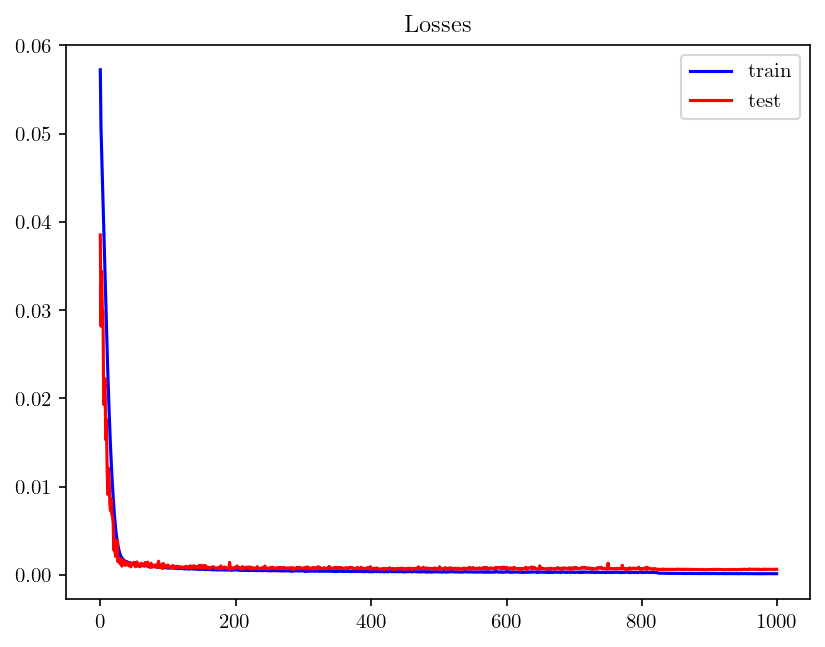

In [38]:
plt.plot(train_losses,'b',label='train')
plt.plot(test_losses,'r',label='test')
plt.legend()
plt.title('Losses')
plt.show();

In [39]:
pretrained = torch.load('../checkpoints/' + tag + '/weights.pt')
# pretrained.keys()+ '/weights.pt')
model.load_state_dict(pretrained['model_state_dict'])

<All keys matched successfully>

In [40]:
path = '../checkpoints/' + tag + '/'
preview(model,preview_loader,device,path,pretrained['epoch'],pretrained['lr'],show=False)

## Checking validation data

In [41]:
losses = torch.load('../checkpoints/' + tag + '/losses.pt')

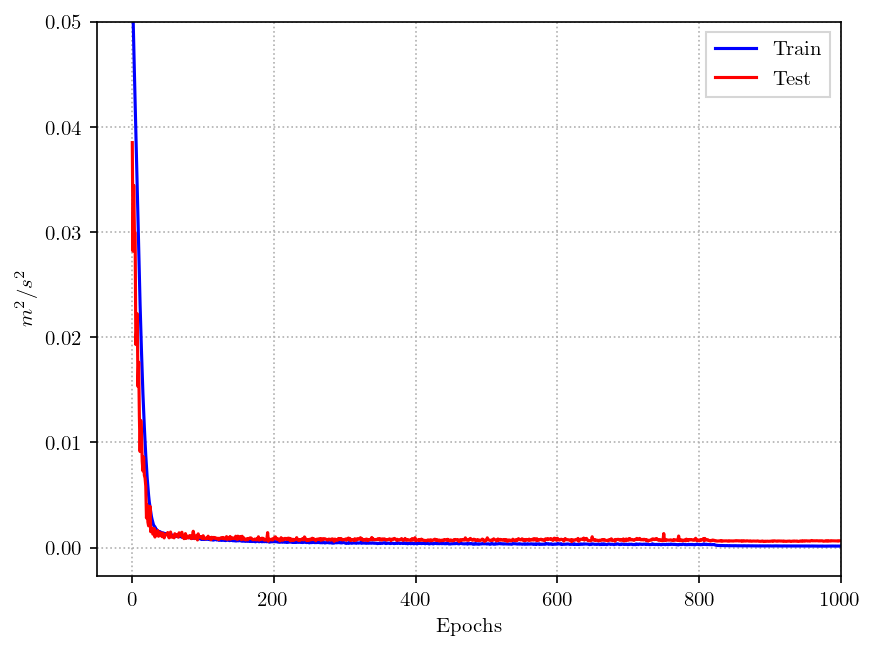

In [47]:
plt.plot(losses['train_losses'],'b',label='Train')
plt.plot(losses['test_losses'],'r',label='Test')
plt.legend(fancybox=False)
plt.xlabel('Epochs')
plt.ylabel('$m^2/s^2$')
plt.grid(linestyle=':')
plt.ylim(top=0.05)
plt.xlim(right=1000)
plt.savefig('../checkpoints/' + tag + '/losses.png')
plt.show();

In [43]:
valid_data = RadarDataset('../synched/fr_V0/valid/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, augment=False, transform=t)

>>> Found 1 files in the selected directory. Building dataset...


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


In [44]:
len(valid_data)

8860

In [45]:
valid_loader = DataLoader(valid_data, batch_size=1, drop_last=False, shuffle=False, pin_memory=True, num_workers=4)

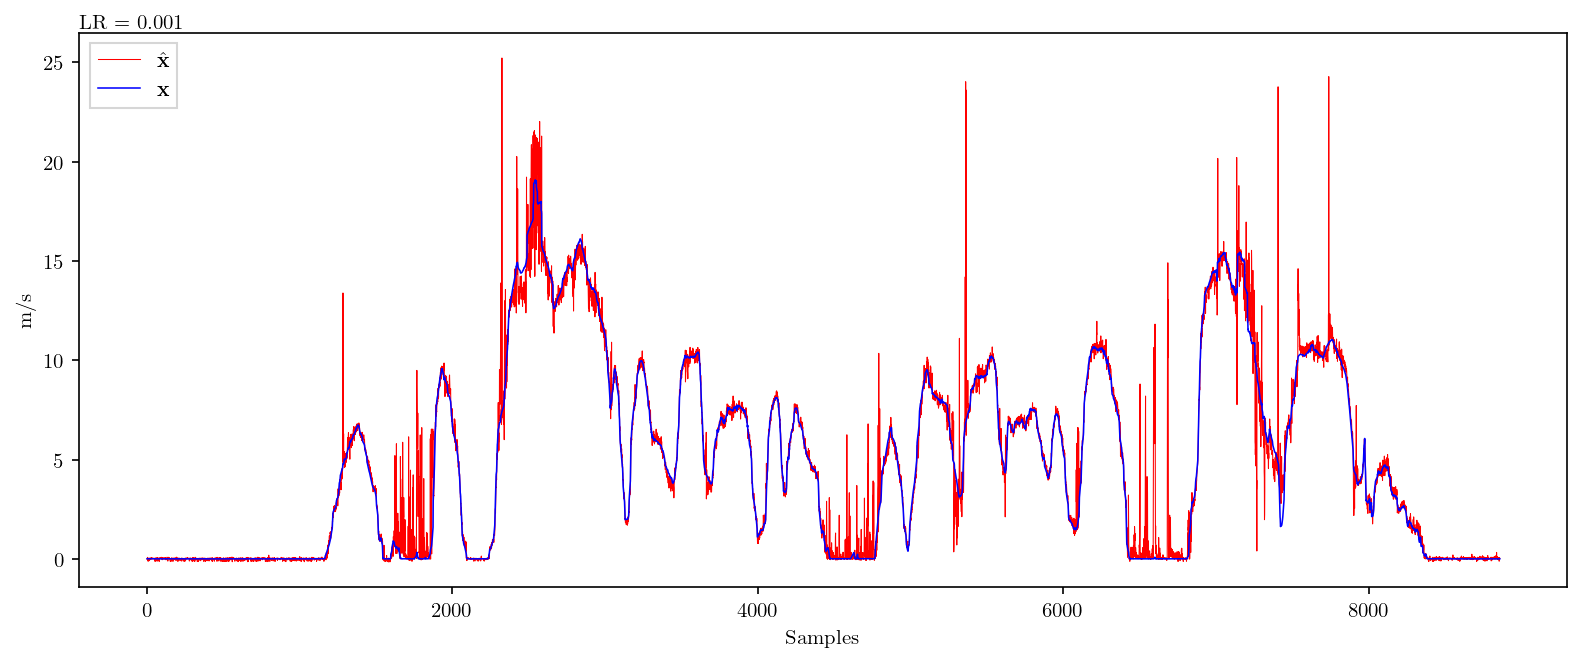

In [46]:
path = '../checkpoints/' + tag + '/'
lr = pretrained['lr']
epoch = 9999
preview(model,valid_loader,device,path,epoch,lr,show=True)